# Tuning ElasticNet models and testing them against external datasets

## Setting up

In [2]:
# setting up
# imports
import pyreadr
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.cross_decomposition import PLSRegression
from scipy.stats import pearsonr
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.svm import SVR, LinearSVR
from sklearn.multioutput import MultiOutputRegressor

# calculate the mean of the pearson coefficients of multiple variables
def pair_pearsonr(x, y, axis=0): # this will allow us to take the pearson coefficient across two variables
    mx = np.mean(x, axis=axis, keepdims=True)
    my = np.mean(y, axis=axis, keepdims=True)
    xm, ym = x-mx, y-my
    r_num = np.add.reduce(xm * ym, axis=axis)
    r_den = np.sqrt((xm*xm).sum(axis=axis) * (ym*ym).sum(axis=axis))
    r = r_num / r_den
    return r

# plotting setup
# Use LaTeX for graphs' text
plt.rc('text', usetex=True)
# Use the serif font
plt.rc('font', family='serif')

In [4]:
# import data, access pandas df via key "None"
X_Govaere = pyreadr.read_r("datasets/X_Govaere.rds")[None]
X_Hoang = pyreadr.read_r("datasets/X_Hoang.rds")[None]
X_Pantano = pyreadr.read_r("datasets/X_Pantano.rds")[None]

# actual, clinical results
Y_Govaere = pyreadr.read_r("datasets/Y_Govaere.rds")[None]
Y_Hoang = pyreadr.read_r("datasets/Y_Hoang.rds")[None]
Y_Pantano = pyreadr.read_r("datasets/Y_Pantano.rds")[None]

# viper metric, predicted results
Y_viper_Govaere = pyreadr.read_r("datasets/viper_X_Govaere.rds")[None]
Y_viper_Hoang = pyreadr.read_r("datasets/viper_X_Hoang.rds")[None]
Y_viper_Pantano = pyreadr.read_r("datasets/viper_X_Pantano.rds")[None]

In [6]:
# setup tuning procedure
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=10)

# select our training dataset
# TODO: CHANGE THE FOLLOWING 3 LINES
training_dataset = "Govaere"
X = X_Govaere
Y = Y_Govaere

In [12]:
# select one of the following:
# linear SVM
params = {
            'epsilon': [0,1e-4,1e-3,1e-2,1e-1,1],
            'C': [1e-1,1, 10, 100, 1000]
            }

model = GridSearchCV(estimator=LinearSVR(),param_grid = params, cv=5, n_jobs=-1)
model = MultiOutputRegressor(model)

# # radial basis function SVM
# params = {
#             'gamma': [1e-5,1e-4,1e-3,1e-2,1e-1,1,1.5,2],
#             'C': [1e-1,1, 10, 100, 1000]
#             }
# model = GridSearchCV(estimator=SVR(kernel='rbf'),param_grid = params, cv=5, n_jobs=-1)
# model = MultiOutputRegressor(model)

# # polynomial SVM
# params = {
#             'gamma': [1e-5,1e-4,1e-3,1e-2,1e-1,1,1.5,2],
#             'C': [1e-1,1, 10, 100, 1000],
#             'degree':[2,3,4,5],
#             'coef0':[0,0.1,0.5,1.,1.2,2.]
#             }
# model = GridSearchCV(estimator=SVR(kernel='poly'),param_grid = params, cv=5, n_jobs=-1)
# model = MultiOutputRegressor(model)

In [44]:
model

MultiOutputRegressor(estimator=GridSearchCV(cv=5, estimator=LinearSVR(),
                                            n_jobs=-1,
                                            param_grid={'C': [0.1, 1, 10, 100,
                                                              1000],
                                                        'epsilon': [0, 0.0001,
                                                                    0.001, 0.01,
                                                                    0.1, 1]}))

## Perform cross validation to find ideal number of latent variables

In [14]:
# For storing fold results
best_params_list = []
test_pearson_coeff_fib = []
test_pearson_coeff_nas = []

# K-fold split for the dataset
for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[0]])):
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit model and get best parameters
    model.fit(X_train, Y_train)
    Y_test_hat = model.predict(X_test)

    # Calculate Pearson correlation for each phenotype
    corr_test_fib, _ = pearsonr(Y_test.values[:, 0], Y_test_hat[:, 0])  # fibrosis correlation
    corr_test_nas, _ = pearsonr(Y_test.values[:, 1], Y_test_hat[:, 1])  # NAS correlation
    test_pearson_coeff_fib.append(corr_test_fib)
    test_pearson_coeff_nas.append(corr_test_nas)

    fold_best_params = [est.best_params_ for est in model.estimators_]
    best_params_list.append(fold_best_params)

# Optionally, average correlations over folds
mean_corr_fib = np.mean(test_pearson_coeff_fib)
mean_corr_nas = np.mean(test_pearson_coeff_nas)

print(f"Mean Pearson correlation (Fibrosis): {mean_corr_fib}")
print(f"Mean Pearson correlation (NAS): {mean_corr_nas}")

/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/_classes.py:31: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/opt/anaconda3/lib/python3.12/site-packages/sklearn/svm/

Mean Pearson correlation (Fibrosis): 0.38097929876849584
Mean Pearson correlation (NAS): 0.5101717189544125


In [42]:
model.estimators_

[GridSearchCV(cv=5, estimator=LinearSVR(), n_jobs=-1,
              param_grid={'C': [0.1, 1, 10, 100, 1000],
                          'epsilon': [0, 0.0001, 0.001, 0.01, 0.1, 1]}),
 GridSearchCV(cv=5, estimator=LinearSVR(), n_jobs=-1,
              param_grid={'C': [0.1, 1, 10, 100, 1000],
                          'epsilon': [0, 0.0001, 0.001, 0.01, 0.1, 1]})]

In [54]:
best_params_list

[[{'C': 0.1, 'epsilon': 1}, {'C': 10, 'epsilon': 1}],
 [{'C': 10, 'epsilon': 1}, {'C': 0.1, 'epsilon': 1}],
 [{'C': 1000, 'epsilon': 1}, {'C': 1, 'epsilon': 1}],
 [{'C': 0.1, 'epsilon': 1}, {'C': 1000, 'epsilon': 1}],
 [{'C': 1, 'epsilon': 1}, {'C': 1000, 'epsilon': 1}]]

In [50]:
test_pearson_coeff_fib
# test_pearson_coeff_nas

[0.35460983529815987,
 0.42827251501547026,
 0.37738141133916386,
 0.4980521390892692,
 0.24663263747217498]

In [52]:
test_pearson_coeff_nas

[0.4825572633538051,
 0.6314261411068903,
 0.5454619231184142,
 0.4101712859454985,
 0.4812361580445926]

## Select best hyperparameters, retrain, and save the model

In [126]:
# save the model so we can run it again
# this time, store the pearson's coeff for training and validation sets

# our best performing hyperparameters (choose index with the highest avg pearson coeffs)
# TODO: CHANGE INDEX
best_params = best_params_list[1] 
train_pearson_coeff_avg = []
train_pearson_coeff_fib = []
train_pearson_coeff_nas = []
test_pearson_coeff_avg = []
test_pearson_coeff_fib = []
test_pearson_coeff_nas = []

model = ElasticNet(alpha = best_params["alpha"], l1_ratio = best_params["l1_ratio"])

for i, (train_index, test_index) in enumerate(skf.split(X, Y[Y.columns[0]])):
    
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

    # Fit model and get best parameters
    model.fit(X_train, Y_train)

    # Calculate Pearson correlation on an average of the two phenotypes
    Y_train_hat = model.predict(X_train) 
    train_pearson_coeff_avg.append(np.mean(pair_pearsonr(Y_train.values, Y_train_hat)))
    
    Y_test_hat = model.predict(X_test) 
    test_pearson_coeff_avg.append(np.mean(pair_pearsonr(Y_test.values, Y_test_hat)))

    # Calculate Pearson correlation for each phenotype
    corr_fib, _ = pearsonr(Y_train.values[:, 0], Y_train_hat[:, 0])  # fibrosis correlation
    corr_nas, _ = pearsonr(Y_train.values[:, 1], Y_train_hat[:, 1])  # NAS correlation
    train_pearson_coeff_fib.append(corr_fib)
    train_pearson_coeff_nas.append(corr_nas)
    
    corr_fib, _ = pearsonr(Y_test.values[:, 0], Y_test_hat[:, 0])  # fibrosis correlation
    corr_nas, _ = pearsonr(Y_test.values[:, 1], Y_test_hat[:, 1])  # NAS correlation
    test_pearson_coeff_fib.append(corr_fib)
    test_pearson_coeff_nas.append(corr_nas)
    
    filename = f"models/{training_dataset}_ElasticNet_fold_{i}.pkl"
    with open(filename, 'wb') as file:
        pickle.dump(model, file)
    
    print(f"Model for Fold {i} saved as {filename}")

Model for Fold 0 saved as models/Pantano_ElasticNet_fold_0.pkl
Model for Fold 1 saved as models/Pantano_ElasticNet_fold_1.pkl
Model for Fold 2 saved as models/Pantano_ElasticNet_fold_2.pkl
Model for Fold 3 saved as models/Pantano_ElasticNet_fold_3.pkl
Model for Fold 4 saved as models/Pantano_ElasticNet_fold_4.pkl


In [128]:
print(f'{train_pearson_coeff_avg=},\n{train_pearson_coeff_fib=},\n{train_pearson_coeff_nas=}, \n{test_pearson_coeff_avg=}, \n{test_pearson_coeff_fib=}, \n{test_pearson_coeff_nas=}')

train_pearson_coeff_avg=[0.9664966405462458, 0.9652164530431079, 0.9644512774998013, 0.962884610449007, 0.9624494607940902],
train_pearson_coeff_fib=[0.9818243255745356, 0.9817618603965671, 0.9791129352167938, 0.9805726127779033, 0.9833127835597227],
train_pearson_coeff_nas=[0.9511689555179569, 0.9486710456896491, 0.9497896197828086, 0.9451966081201104, 0.9415861380284568], 
test_pearson_coeff_avg=[0.7188979463503028, 0.6949811264372294, 0.7193095744344402, 0.6386694065015521, 0.6398112861480436], 
test_pearson_coeff_fib=[0.7591536810114479, 0.7044916004909192, 0.7292688473107802, 0.5516759430671664, 0.6467501048915213], 
test_pearson_coeff_nas=[0.6786422116891573, 0.6854706523835398, 0.7093503015581, 0.7256628699359373, 0.632872467404566]


In [130]:
# load all models
loaded_models = []
for i in range(0, 5):
    filename = f"models/{training_dataset}_ElasticNet_fold_{i}.pkl"
    with open(filename, 'rb') as file:
        model = pickle.load(file)
        loaded_models.append(model)
    print(f"Loaded model {i} from {filename}")

Loaded model 0 from models/Pantano_ElasticNet_fold_0.pkl
Loaded model 1 from models/Pantano_ElasticNet_fold_1.pkl
Loaded model 2 from models/Pantano_ElasticNet_fold_2.pkl
Loaded model 3 from models/Pantano_ElasticNet_fold_3.pkl
Loaded model 4 from models/Pantano_ElasticNet_fold_4.pkl


## Test with the best model on external and shuffled datasets

In [132]:
# create shuffled dataset from training dataset
X_shuffled = X.apply(lambda col: np.random.permutation(col.values), axis=0)
X_shuffled.index = X.index # ensure the gene names are maintained

In [134]:
# run on the other two external test sets and the shuffled training dataset
# TODO: CHANGE THE FOLLOWING 6 LINES
test1 = "Govaere"
test2 = "Hoang"
X_test1 = X_Govaere
X_test2 = X_Hoang
Y_test1 = Y_Govaere
Y_test2 = Y_Hoang

test1_pearson_coeff = []
test2_pearson_coeff = []
shuffled_pearson_coeff = []

for i, model in enumerate(loaded_models):
    Y_pred = model.predict(X_test1)
    test1_pearson_coeff.append(np.mean(pair_pearsonr(Y_test1.values, Y_pred)))

    Y_pred = model.predict(X_test2)
    test2_pearson_coeff.append(np.mean(pair_pearsonr(Y_test2.values, Y_pred)))

    Y_pred = model.predict(X_shuffled)
    shuffled_pearson_coeff.append(np.mean(pair_pearsonr(Y.values, Y_pred)))


In [136]:
# store all pearson correlation coefficients in a dataframe
all_coeff = {
    'Train': train_pearson_coeff_avg,
    'Validation': test_pearson_coeff_avg,
    test1: test1_pearson_coeff,
    test2: test2_pearson_coeff,
    'Shuffled': shuffled_pearson_coeff
}

all_pearsons_coeff = pd.DataFrame(all_coeff)

## Plot with Mann-Whitney test

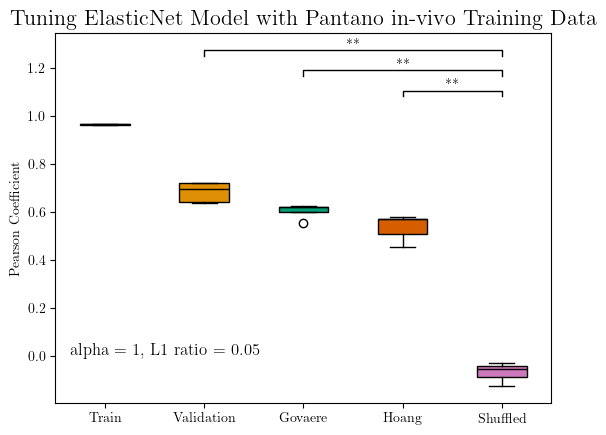

In [138]:
significant_combinations = []

combinations = [(x, 4) for x in [1, 2, 3]]
for combo in combinations:
    data1 = all_pearsons_coeff.iloc[:,combo[0]]
    data2 = all_pearsons_coeff.iloc[:,combo[1]]
    
    # calculate significance
    U, p = stats.mannwhitneyu(data1, data2, alternative='two-sided')
    if p < 0.05:
        significant_combinations.append([combo, p])

# create a set of axes
ax = plt.axes()
# create a boxplot on the axes
bp = ax.boxplot(all_pearsons_coeff, patch_artist=True)
# graph title TODO: CHANGE
ax.set_title(f"Tuning ElasticNet Model with {training_dataset} in-vivo Training Data", fontsize=16)
# label y-axis
ax.set_ylabel("Pearson Coefficient")

xticklabels = all_pearsons_coeff.columns.tolist()
ax.set_xticklabels(xticklabels)

# Change the colour of the boxes to Seaborn's 'pastel' palette
colors = sns.color_palette('colorblind')
for patch, color in zip(bp['boxes'], colors):
    patch.set_facecolor(color)

# Colour of the median lines
plt.setp(bp['medians'], color='k')

# Get the y-axis limits
bottom, top = ax.get_ylim()
y_range = top - bottom

# Significance bars
for i, significant_combination in enumerate(significant_combinations):
    # Columns corresponding to the datasets of interest
    # add one because the df indexing is 0 indexed, but plot is 1 indexed
    x1 = significant_combination[0][0] + 1 
    x2 = significant_combination[0][1] + 1
    # What level is this bar among the bars above the plot?
    level = len(significant_combinations) - i
    # Plot the bar
    bar_height = (y_range * 0.07 * level) + top
    bar_tips = bar_height - (y_range * 0.02)
    plt.plot(
        [x1, x1, x2, x2],
        [bar_tips, bar_height, bar_height, bar_tips], lw=1, c='k'
    )
    # Significance level
    p = significant_combination[1]
    if p < 0.001:
        sig_symbol = '***'
    elif p < 0.01:
        sig_symbol = '**'
    elif p < 0.05:
        sig_symbol = '*'
    text_height = bar_height + (y_range * 0.01)
    plt.text((x1 + x2) * 0.5, text_height, sig_symbol, ha='center', va='bottom', c='k')

# label the hyperparameter value
plt.text(0.65, 0.00, f'alpha = {best_params["alpha"]}, L1 ratio = {best_params["l1_ratio"]}', fontsize = 12)

#TODO: CHANGE
plt.savefig(f'graphs/ElasticNet_tuning_with_{training_dataset}.png', dpi=200)
plt.show()

In [86]:
significant_combinations

[[(1, 4), 0.007936507936507936],
 [(2, 4), 0.007936507936507936],
 [(3, 4), 0.007936507936507936]]